In [4]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point  # <-- Faltaba este import
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Cargar shapefiles
gdf_depositos = gpd.read_file("C:/Git_SCA/AGE/Depositos").to_crs(epsg=4326)
gdf_moho = gpd.read_file("C:/Git_SCA/AGE/Corteza").to_crs(epsg=4326)
gdf_dataciones = gpd.read_file("C:/Git_SCA/AGE/Dataciones").to_crs(epsg=4326)
gdf_gradiente = gpd.read_file("C:/Git_SCA/AGE/Geotermica").to_crs(epsg=4326)

# Crear pseudo-ausencias
gdf_depositos["Presencia"] = 1
num_depos = len(gdf_depositos)
rng = np.random.default_rng(42)
pseudo_points = [Point(rng.uniform(-80, -65), rng.uniform(-5, 15)) for _ in range(num_depos)]
gdf_aus = gpd.GeoDataFrame(geometry=pseudo_points, crs="EPSG:4326")
gdf_aus["Presencia"] = 0

# Unir y extraer coordenadas
gdf_total = pd.concat([gdf_depositos, gdf_aus], ignore_index=True)
gdf_total["X"] = gdf_total.geometry.x
gdf_total["Y"] = gdf_total.geometry.y

# Interpolaciones
def interpolar(gdf, columna, grid_x, grid_y, filtro=None):
    gdf = gdf.copy()
    gdf[columna] = pd.to_numeric(gdf[columna].astype(str).str.replace(",", "."), errors="coerce")
    if filtro:
        gdf = gdf.query(filtro)
    coords = np.array([[p.x, p.y] for p in gdf.geometry])
    valores = gdf[columna].values
    grid = griddata(coords, valores, (grid_x, grid_y), method="cubic")
    grid[np.isnan(grid)] = griddata(coords, valores, (grid_x[np.isnan(grid)], grid_y[np.isnan(grid)]), method="nearest")
    return grid

grid_x, grid_y = np.mgrid[-80:-65:500j, -5:15:500j]
grid_moho = interpolar(gdf_moho, "Z", grid_x, grid_y)
grid_edad = interpolar(gdf_dataciones, "EdadMa", grid_x, grid_y, "EdadMa <= 4000")
grid_grad = interpolar(gdf_gradiente, "GRADIENTE", grid_x, grid_y)

def sample_grid_value(x, y, grid, xmin=-80, xmax=-65, ymin=-5, ymax=15, n=500):
    ix = int((x - xmin) / ((xmax - xmin) / n))
    iy = int((ymax - y) / ((ymax - ymin) / n))
    if 0 <= ix < n and 0 <= iy < n:
        return grid[iy, ix]
    return np.nan

gdf_total["Moho_Z"] = gdf_total.apply(lambda r: sample_grid_value(r.X, r.Y, grid_moho), axis=1)
gdf_total["EdadMa"] = gdf_total.apply(lambda r: sample_grid_value(r.X, r.Y, grid_edad), axis=1)
gdf_total["Gradiente"] = gdf_total.apply(lambda r: sample_grid_value(r.X, r.Y, grid_grad), axis=1)

# Dataset final
gdf_modelo = gdf_total.dropna(subset=["Moho_Z", "EdadMa", "Gradiente"])
gdf_modelo = gdf_modelo[gdf_modelo["EdadMa"] <= 4000].copy()



Intercepto: -0.26711084066028457
Coeficientes: {'Moho_Z': 0.016937763235165285, 'EdadMa': 0.00012490902162855065, 'Gradiente': 3.66557748848246e-05}
R2: 0.3157118648103988
RMSE: 0.4135385997997961


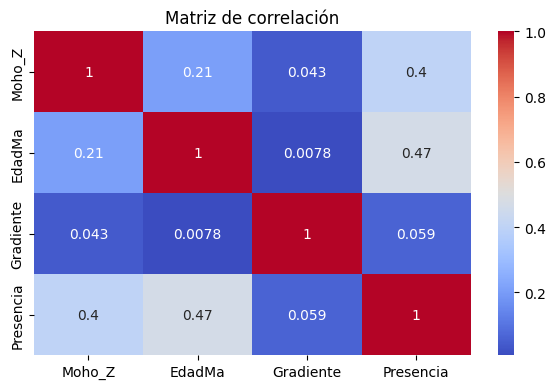

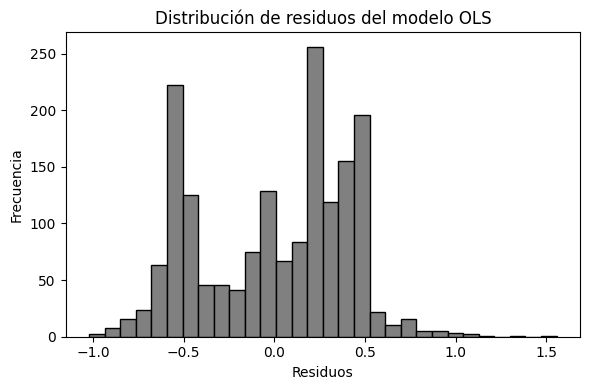

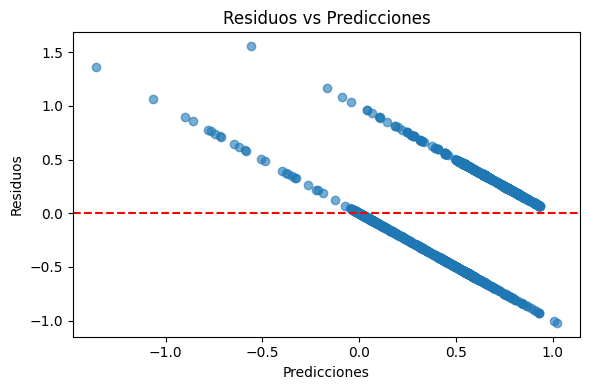

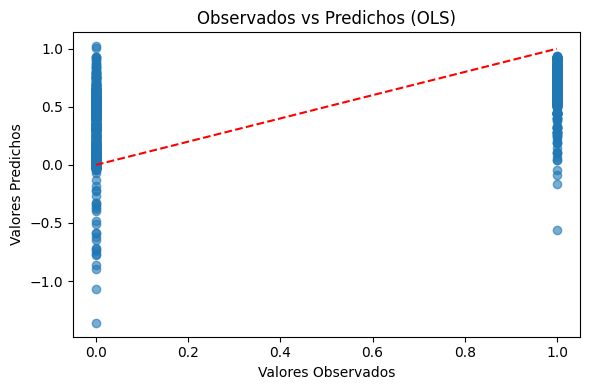

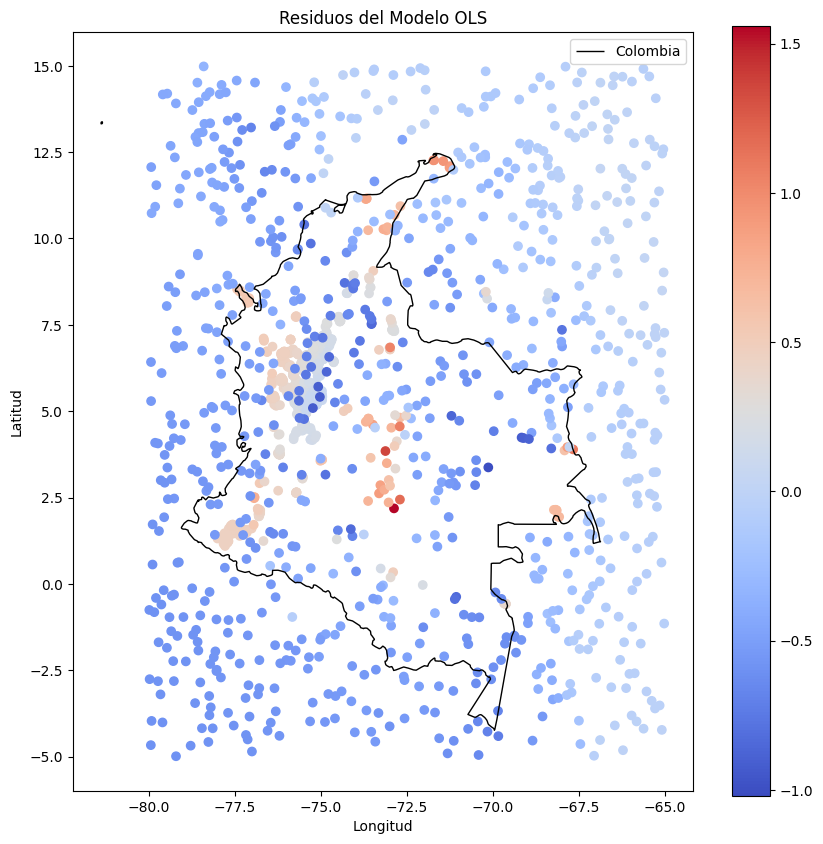

In [7]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
area_col = gpd.read_file("C:/Git_SCA/AGE/Area_Col").to_crs(epsg=4326)
# === Datos ===
X = gdf_modelo[["Moho_Z", "EdadMa", "Gradiente"]]
y = gdf_modelo["Presencia"]

# === Modelo OLS ===
modelo_ols = LinearRegression()
modelo_ols.fit(X, y)

# === Predicciones y residuos ===
gdf_modelo["pred_ols"] = modelo_ols.predict(X)
gdf_modelo["residuos_ols"] = y - gdf_modelo["pred_ols"]

# === Estadísticos ===
print("Intercepto:", modelo_ols.intercept_)
print("Coeficientes:", dict(zip(X.columns, modelo_ols.coef_)))
print("R2:", r2_score(y, gdf_modelo["pred_ols"]))
print("RMSE:", np.sqrt(mean_squared_error(y, gdf_modelo["pred_ols"])))

# === Matriz de correlación ===
plt.figure(figsize=(6, 4))
sns.heatmap(gdf_modelo[["Moho_Z", "EdadMa", "Gradiente", "Presencia"]].corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()

# === Histograma de residuos ===
plt.figure(figsize=(6, 4))
plt.hist(gdf_modelo["residuos_ols"], bins=30, color="gray", edgecolor="black")
plt.title("Distribución de residuos del modelo OLS")
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# === Gráfico residuos vs predicciones ===
plt.figure(figsize=(6, 4))
plt.scatter(gdf_modelo["pred_ols"], gdf_modelo["residuos_ols"], alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Residuos vs Predicciones")
plt.tight_layout()
plt.show()

# === Comparación observados vs predichos ===
plt.figure(figsize=(6, 4))
plt.scatter(y, gdf_modelo["pred_ols"], alpha=0.6)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("Valores Observados")
plt.ylabel("Valores Predichos")
plt.title("Observados vs Predichos (OLS)")
plt.tight_layout()
plt.show()

# === Mapa de residuos OLS con contorno de Colombia ===
fig, ax = plt.subplots(figsize=(10, 10))
# Contorno de Colombia (frontera)
area_col.boundary.plot(ax=ax, color='black', linewidth=1, label="Colombia")
# Residuos del modelo
gdf_modelo.plot(column="residuos_ols", cmap="coolwarm", ax=ax, legend=True)
plt.title("Residuos del Modelo OLS")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend()
plt.show()
